# Grid search analysis

In this notebook, we take go through the training .csv files produced from the deep neural network learning notebook and find the best performing model given the search parameters and input data.

For the google colab - the basic presciption is to copy the drugdiscovery library into a google drive folder and import the library in the colab notebook from the drive. Accessing google drive is done in the following step below:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

root = '/content/gdrive/My Drive/drug_discovery/DrugDiscovery/'
# root is the root folder where the library is held.

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 1. Imports

In [12]:

# Basic imports
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Sklearn data preprocessing imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# drugdiscovery code imports
import sys
sys.path.insert(1, root)
sys.path.insert(1, root + 'drugdiscovery')

import drugdiscovery as dd
from drugdiscovery import preprocessing as pp
from drugdiscovery import deeplearning as dl
from drugdiscovery import testing as tt

# torch imports
import torch
import torch.nn.functional as F
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

from os import listdir
from tqdm import tqdm_notebook
import collections
import itertools

cuda:0


### 2. Re-computing all grid searching file inputs

We grid searched over specific data inputs by creating a `training_configurations` and `testing_configurations` object which is an array which keeps a string representation of the data input configurations employed.

In [5]:
train_inputs = [
 #         'bow_train',
          'X_train_fp',
          'X_train_tox',
          'X_train_desc',
]


all_combinations = []
for r in range(len(train_inputs) +1):

    combinations_object = itertools.combinations(train_inputs, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list

training_configurations = []
for x in all_combinations[1:]:
  config = '[' + ','.join(list(x)) + ']'
  training_configurations.append(config)
  if 'bow_train' in config:
    config = config.replace("bow_train", "bow_train_svd")
    training_configurations.append(config)
  if 'X_train_fp' in config:
    config = config.replace("X_train_fp", "X_train_fp_svd")
    training_configurations.append(config)

testing_configurations = []
for configs in training_configurations:
    config = configs.replace("train", "test")
    testing_configurations.append(config)

### 3. Find the files and do basic checks
In this subsection, we find the .csv files that we created and perform the three checks:

1. First, we delete those dataframes that have any nulls in them, since this would imply that early stopping occured during training and we would like to exclude them.

2. Visualise the AUPRC (area under precision-recall curve) over increasing epochs.

3. Visualise the validation loss over increasing epochs.

In [9]:
def find_csv_filenames( path_to_dir:str, suffix:str=".csv" )->list:
    """
    Given the path to directory, produces a list of all files with a specific suffix.
    """
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]


model_results = find_csv_filenames(root + 'models/dnn_models/')
len(model_results)

66

Let's check one as an example:

In [10]:
pd.read_csv(root+'models/dnn_models/' + model_results[4]).dropna()

,Epochs,train loss,val loss,val auprc
0,1,34.549190,0.425395,0.195716
1,2,33.290304,0.437150,0.272544
2,3,32.218788,0.418430,0.311090
3,4,31.269820,0.401769,0.333613
4,5,30.271683,0.380142,0.341389
...,...,...,...,...
195,196,3.946519,0.203396,0.399338
196,197,3.941642,0.201511,0.396918
197,198,3.869435,0.202017,0.396872
198,199,3.909256,0.202825,0.396117


1. Exclude all models that have nulls in them:

In [11]:
model_res = []
for res in tqdm_notebook(model_results):
  if pd.read_csv(root+'models/dnn_models/' + res).isnull().sum()['val auprc']!=0:
    continue
  else:
    model_res.append(res)

In [13]:
len(model_res)

22

2 and 3. Valualise the validation losses:

From this we can see that all models stablise in the validation loss at some point between 40-60 epoch, however there is still a relatively large span of models.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, y)
ax2.plot(x, -y)

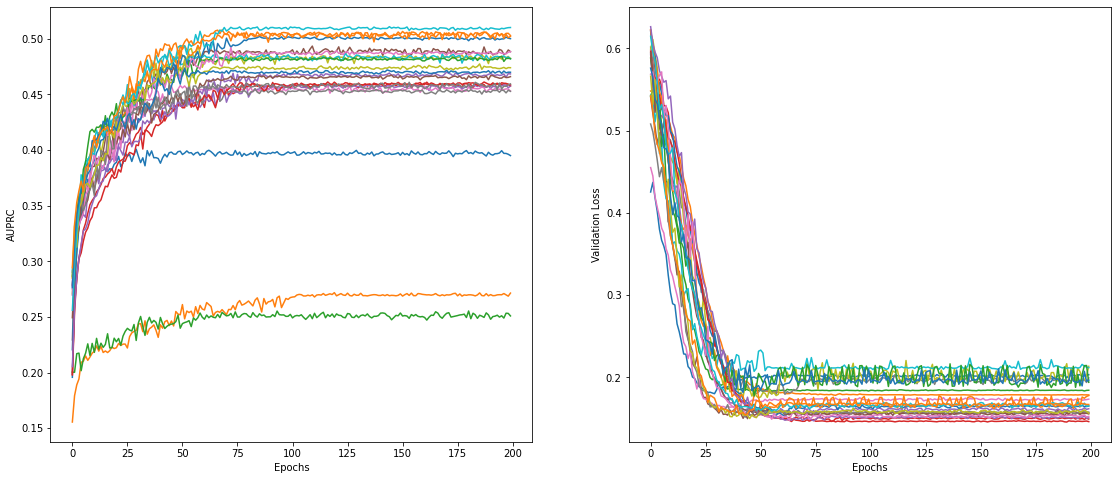

In [22]:
auprc = []
loss = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (19,8))

for res in model_res:
  filename = root+'models/dnn_models/' + res
  df = pd.read_csv(filename,index_col = 0)
  
  temp = df.tail(10)[['val loss','val auprc']].mean().to_dict()
  auprc.append(temp['val auprc'])
  loss.append(temp['val loss'])
  
  ax1.plot(df['val auprc'].values)
  ax2.plot(df['val loss'].values)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('AUPRC')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss');

So we see that the validation of most of the models appear to be decreasing at somewhat the same rate, however the area under precision-recall curve appears to give veryy distinctive retults. 

### 4. Selecting the model

In this subsection we find the model that best performs accoridng the AUPRC.

In [23]:
AUPRC = np.argsort(np.array(auprc))[::-1]
LOSS = np.argsort(np.array(loss))

The top three models according to the AURPC:

In [4]:
a=["SR-HSE	0.4	0.277778	0.327869	0.341085	0.937879	0.62687	0.62687",
"NR-AR	0.666667	0.454545	0.540541	0.526299	0.977212	0.72382	0.72382",
"SR-ARE	0.670103	0.601852	0.634146	0.641071	0.874372	0.768206	0.768206",
"NR-Aromatase	0.62963	0.515152	0.566667	0.58764	0.956811	0.748788	0.748788",
"NR-ER-LBD	0.454545	0.285714	0.350877	0.442262	0.948179	0.634021	0.634021",
"NR-AhR	0.689655	0.526316	0.597015	0.678326	0.919403	0.748006	0.748006",
"SR-MMP	0.717391	0.680412	0.698413	0.777485	0.90339	0.813837	0.813837",
"NR-ER	0.536585	0.293333	0.37931	0.414401	0.884984	0.629425	0.629425",
"NR-PPAR-gamma	0.272727	0.176471	0.214286	0.205877	0.965891	0.581866	0.581866",
"SR-p53	0.576923	0.3	0.394737	0.481543	0.932353	0.64127	0.64127",
"SR-ATAD5	0.466667	0.304348	0.368421	0.428118	0.966667	0.646435	0.646435",
"NR-AR-LBD	0.5	0.5625	0.529412	0.592103	0.976744	0.774554	0.774554"]

In [11]:
for i in range(0,len(a)):
    print('|'.join(a[i].split('\t')))

SR-HSE|0.4|0.277778|0.327869|0.341085|0.937879|0.62687|0.62687
NR-AR|0.666667|0.454545|0.540541|0.526299|0.977212|0.72382|0.72382
SR-ARE|0.670103|0.601852|0.634146|0.641071|0.874372|0.768206|0.768206
NR-Aromatase|0.62963|0.515152|0.566667|0.58764|0.956811|0.748788|0.748788
NR-ER-LBD|0.454545|0.285714|0.350877|0.442262|0.948179|0.634021|0.634021
NR-AhR|0.689655|0.526316|0.597015|0.678326|0.919403|0.748006|0.748006
SR-MMP|0.717391|0.680412|0.698413|0.777485|0.90339|0.813837|0.813837
NR-ER|0.536585|0.293333|0.37931|0.414401|0.884984|0.629425|0.629425
NR-PPAR-gamma|0.272727|0.176471|0.214286|0.205877|0.965891|0.581866|0.581866
SR-p53|0.576923|0.3|0.394737|0.481543|0.932353|0.64127|0.64127
SR-ATAD5|0.466667|0.304348|0.368421|0.428118|0.966667|0.646435|0.646435
NR-AR-LBD|0.5|0.5625|0.529412|0.592103|0.976744|0.774554|0.774554


In [25]:
np.array(auprc)[AUPRC[:3]]

array([0.50923616, 0.50312269, 0.50292795])

In [26]:
np.array(model_res)[AUPRC[:3]]

array(['config_N10_1024_2048_wpca.csv',
       'config_N10_1024_2048_4196_wpca.csv',
       'config_N7_1024_2048_wpca.csv'], dtype='<U34')

What is N10?

In [27]:
training_configurations[10],training_configurations[7]

('[X_train_fp_svd,X_train_tox,X_train_desc]', '[X_train_fp_svd,X_train_desc]')

The model specification `'config_N10_1024_2048_wpca.csv'` is therefore as follows:

1. Data inputs are `[X_train_fp_svd,X_train_tox,X_train_desc]`, that is the SVD truncated fingerprint data, the toxicophores and the quantitative molecular descriptors.

2. There is a PCA preprocessing step which halves the number of data inputs.

3. The model layers are `[1024, 2048]`.

# 5. Re-train model

Since we did not save the model parameters, we can retrain the model here. however, first we need to perform all of the preprocessing steps from the modelling notebook - there are exactly the same steps:

In [28]:

# drugdiscovery code imports

source_data = root+'data/data_dups_removed_with_H.csv'
molecular_descriptors = root + 'data/molecular_descriptors_from_source.csv'
fingerprint = root + 'data/morgan_fingerprint_from_source_10.csv'
toxicophores = root +'data/known_toxic.csv'

source_data, molecular_descriptors, fingerprint, toxicophores = \
[pd.read_csv(x, index_col = 0) for x in [source_data, molecular_descriptors, fingerprint, toxicophores]]

source_features = ['FW','SMILES']
targets = ['SR-HSE','NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',\
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']


#dealing the source data
raw_y = source_data[targets]
raw_X = source_data[source_features]

null_mask = np.array(np.logical_not(raw_y.isnull().values),int)
raw_y = raw_y.fillna(0.0)
mask_df = pd.DataFrame(null_mask, columns = [r+'_mask' for r in raw_y.columns], index = raw_y.index)

# The masks are attached to the raw target set, so it is easier to move this data around.
raw_y = pd.concat([raw_y,mask_df],1)


test_size = 0.1
X_train_source, X_test_source, y_train, y_test = train_test_split(raw_X, raw_y, test_size = test_size, random_state=42)

training_index = X_train_source.index
testing_index = X_test_source.index

#fingerprints
fp_cols = list(fingerprint.columns)
fp_cols.remove('DSSTox_CID')
fp_cols.remove('SMILES')
X_train_fp, X_test_fp = fingerprint[fp_cols].loc[training_index],fingerprint[fp_cols].loc[testing_index]

# descriptors
desc_cols = list(molecular_descriptors.columns)
desc_cols.remove('SMILES')
X_train_desc, X_test_desc = molecular_descriptors[desc_cols].loc[training_index],\
                                                molecular_descriptors[desc_cols].loc[testing_index]

# known toxic
X_train_tox, X_test_tox = toxicophores.loc[training_index],\
                                                toxicophores.loc[testing_index]

# finally, we separate out the training from the mask data.
y_train, mask_train = y_train[targets],y_train[mask_df.columns]
y_test, mask_test = y_test[targets],y_test[mask_df.columns]

def transform(train, test, apply_transformer):
  train_new = apply_transformer.fit_transform(train)
  test_new = apply_transformer.transform(test)
  return train_new, test_new

# The source dataset
smiles = X_train_source['SMILES'].values
bow = pp.BagOfWordsMols(smiles)
bow_train = bow.fit()
bow_test = bow.transform(X_test_source['SMILES'].values)

bow_train = np.insert(bow_train, 0, X_train_source['FW'], 1)
bow_test = np.insert(bow_test, 0, X_test_source['FW'], 1)

# Standardise the data
bow_train, bow_test = transform(bow_train, bow_test, StandardScaler())

# Standardise the toxicophores dataset
X_train_tox, X_test_tox = transform(X_train_tox, X_test_tox, StandardScaler())

#standardise the molecular description dataset
X_train_desc, X_test_desc = transform(X_train_desc, X_test_desc, StandardScaler())


from sklearn.decomposition import TruncatedSVD

X_train_fp_svd, X_test_fp_svd = transform(X_train_fp, X_test_fp, TruncatedSVD(1024))
bow_train_svd, bow_test_svd = transform(bow_train, bow_test, TruncatedSVD(50))

from sklearn.decomposition import PCA
def prepare_data(with_pca, batch_size, y_train, y_test, mask_train, mask_test, training_data, testing_data):
  """
  Always use PCA to half the size.
  """
  X_train = np.concatenate(training_data,1)
  X_test = np.concatenate(testing_data,1)

  if with_pca:
    N,p = X_train.shape
    pca_shape = int(p/2)
    pca = PCA(pca_shape)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

  train_set, test_set, train_loader, number_of_batches = dl.get_data(X_train, y_train, mask_train, X_test, y_test, mask_test,batch_size)
  return train_set, test_set, train_loader, number_of_batches

We can now traint the model:

In [29]:
from IPython.display import clear_output
def run(epochs, layers, config_n, final_pca):
  print('Working in config ',config_n)
  print('INPUTS : ',training_configurations[config_n])
  print('LAYERS : ',layers)
  print('WITH FINAL PCA : ',final_pca)

  train_set, test_set, train_loader, number_of_batches = prepare_data(final_pca, 128,  y_train, y_test, mask_train, \
                                                                        mask_test, eval(training_configurations[config_n]),eval(testing_configurations[config_n]))
  
  p = train_set[0][0].shape[0]
  activations = [torch.relu]*len(layers)
  early_stopper = dl.EarlyStopping(patience=10)
  model = dl.net(p, 12, seed = 12345, hidden_layers = layers, activations = activations).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=4e-5,weight_decay= 1e-5)
  criterion = nn.BCELoss()
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose = False)
  training_module = dl.Trainer(model, optimizer,criterion,epochs, root, device, scheduler ,early_stopper)
  model_name = 'config_N'+ str(config_n) +'_'+'_'.join([str(l) for l in layers])
  results = training_module.train_model(train_loader, test_set, number_of_batches, targets, mask_train, mask_test, model_name)
  return results, model, train_set,test_set

In [30]:
results, model, train_set,test_set = run(200,[1024,2048],10,True)

Working in config  10
INPUTS :  [X_train_fp_svd,X_train_tox,X_train_desc]
LAYERS :  [1024, 2048]
WITH FINAL PCA :  True
Epoch [0/200] :: train loss: 34.161045 val loss: 0.602952 - val AUPRC: 0.260 - val AUCROC :0.752
 Epoch [9/200]Epoch [10/200] :: train loss: 25.867730 val loss: 0.446901 - val AUPRC: 0.400 - val AUCROC :0.828
 Epoch [19/200]Epoch [20/200] :: train loss: 16.410957 val loss: 0.298411 - val AUPRC: 0.424 - val AUCROC :0.824
 Epoch [29/200]Epoch [30/200] :: train loss: 9.738246 val loss: 0.193256 - val AUPRC: 0.465 - val AUCROC :0.838
 Epoch [39/200]Epoch [40/200] :: train loss: 6.812831 val loss: 0.162129 - val AUPRC: 0.478 - val AUCROC :0.841
 Epoch [49/200]Epoch [50/200] :: train loss: 5.348932 val loss: 0.158234 - val AUPRC: 0.499 - val AUCROC :0.844
 Epoch [59/200]Epoch [60/200] :: train loss: 4.380383 val loss: 0.165198 - val AUPRC: 0.496 - val AUCROC :0.838
 Epoch [69/200]Epoch [70/200] :: train loss: 3.566907 val loss: 0.165701 - val AUPRC: 0.507 - val AUCROC :0.84

In [31]:
model

net(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=614, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=2048, bias=True)
  )
  (constant_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (output): Linear(in_features=2048, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (bat): ModuleList(
    (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

### 6. Tests

In this section, a panel of tests of shown for both the testing set and then the training set. Precsion-Recall plots are shown for these sets also.

#### 6a. Testing set

In [34]:
X_test, y_test, mask_test = test_set[:]

In [35]:
test_panel = tt.panel_of_test(targets, X_test, y_test, sample_weights = mask_test)
y_score = model(torch.tensor(X_test).cuda().float()).cpu().detach().numpy()
y_pred = np.array(y_score>0.5)
metrics = test_panel.compute_basic_metrics(y_pred, y_score)

In [36]:
metrics

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,0.4,0.277778,0.327869,0.341085,0.937879,0.62687,0.62687
NR-AR,0.666667,0.454545,0.540541,0.526299,0.977212,0.72382,0.72382
SR-ARE,0.670103,0.601852,0.634146,0.641071,0.874372,0.768206,0.768206
NR-Aromatase,0.62963,0.515152,0.566667,0.58764,0.956811,0.748788,0.748788
NR-ER-LBD,0.454545,0.285714,0.350877,0.442262,0.948179,0.634021,0.634021
NR-AhR,0.689655,0.526316,0.597015,0.678326,0.919403,0.748006,0.748006
SR-MMP,0.717391,0.680412,0.698413,0.777485,0.90339,0.813837,0.813837
NR-ER,0.536585,0.293333,0.37931,0.414401,0.884984,0.629425,0.629425
NR-PPAR-gamma,0.272727,0.176471,0.214286,0.205877,0.965891,0.581866,0.581866
SR-p53,0.576923,0.3,0.394737,0.481543,0.932353,0.64127,0.64127


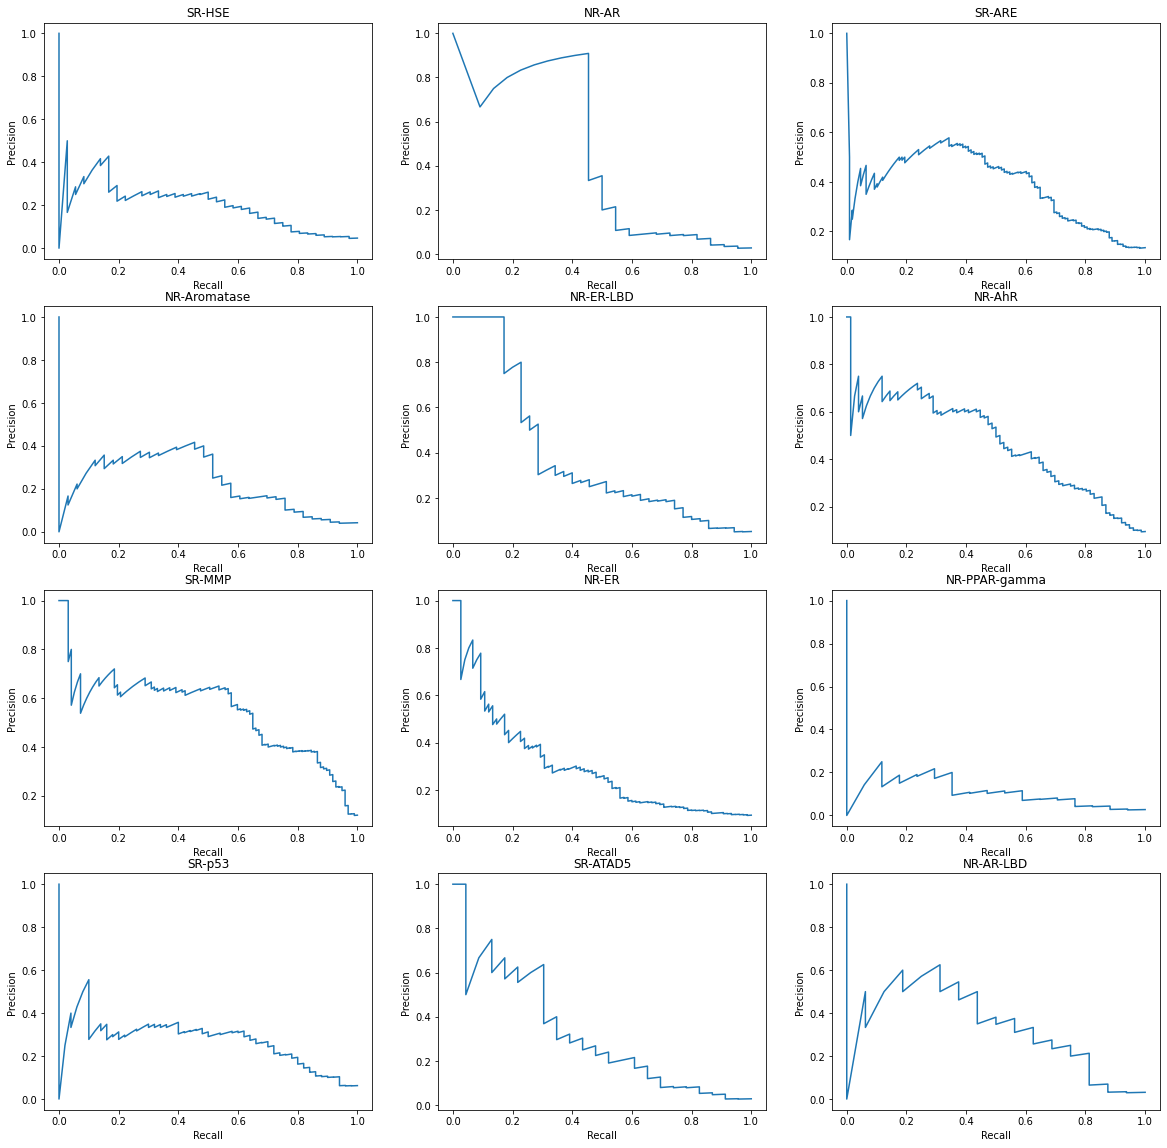

In [37]:
test_panel.plot_recall_precision(y_score, extra_index = False)

#### 6b. Training set

In [38]:
X_train, y_train, mask_train = train_set[:]

In [39]:
test_panel = tt.panel_of_test(targets, X_train, y_train, sample_weights = mask_train)
y_score = model(torch.tensor(X_train).cuda().float()).cpu().detach().numpy()
y_pred = np.array(y_score>0.5)
metrics = test_panel.compute_basic_metrics(y_pred, y_score)

In [40]:
metrics

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,0.962687,0.752187,0.844517,0.941466,0.984042,0.875202,0.875202
NR-AR,0.985222,0.694444,0.814664,0.937162,0.986452,0.846989,0.846989
SR-ARE,0.986318,0.922093,0.953125,0.986788,0.985445,0.959824,0.959824
NR-Aromatase,0.983122,0.838129,0.904854,0.969484,0.990857,0.918671,0.918671
NR-ER-LBD,0.963636,0.822981,0.887772,0.957214,0.989562,0.910671,0.910671
NR-AhR,0.976261,0.926761,0.950867,0.988454,0.988744,0.96188,0.96188
SR-MMP,0.987864,0.964455,0.976019,0.996827,0.992519,0.981117,0.981117
NR-ER,0.965392,0.732044,0.832679,0.938199,0.962658,0.864114,0.864114
NR-PPAR-gamma,0.992754,0.796512,0.883871,0.953089,0.993957,0.898169,0.898169
SR-p53,0.974138,0.889764,0.930041,0.981871,0.991835,0.944115,0.944115


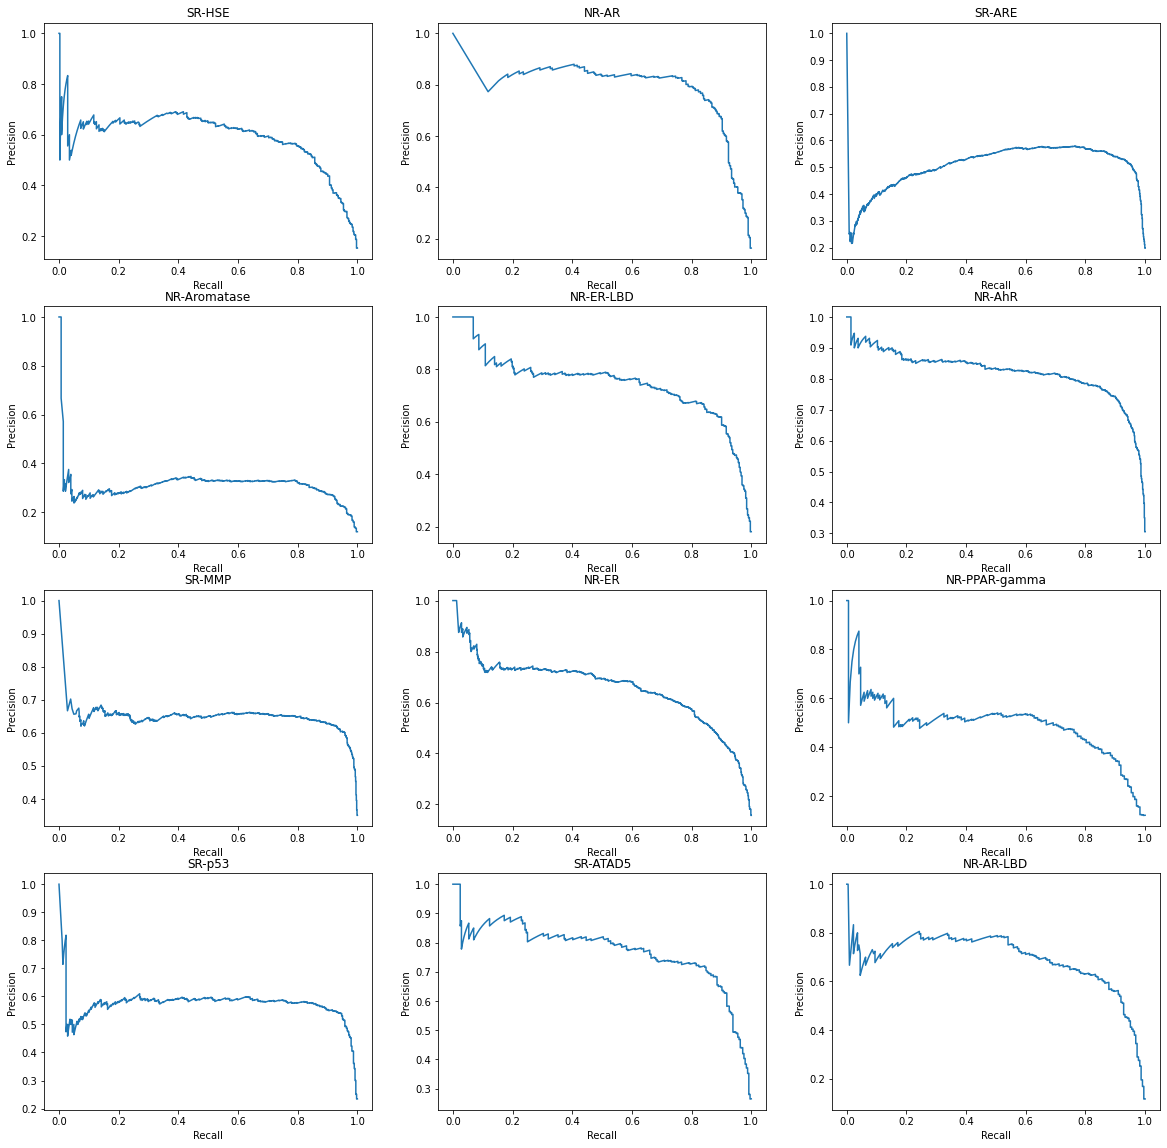

In [41]:
test_panel.plot_recall_precision(y_score, extra_index = False)